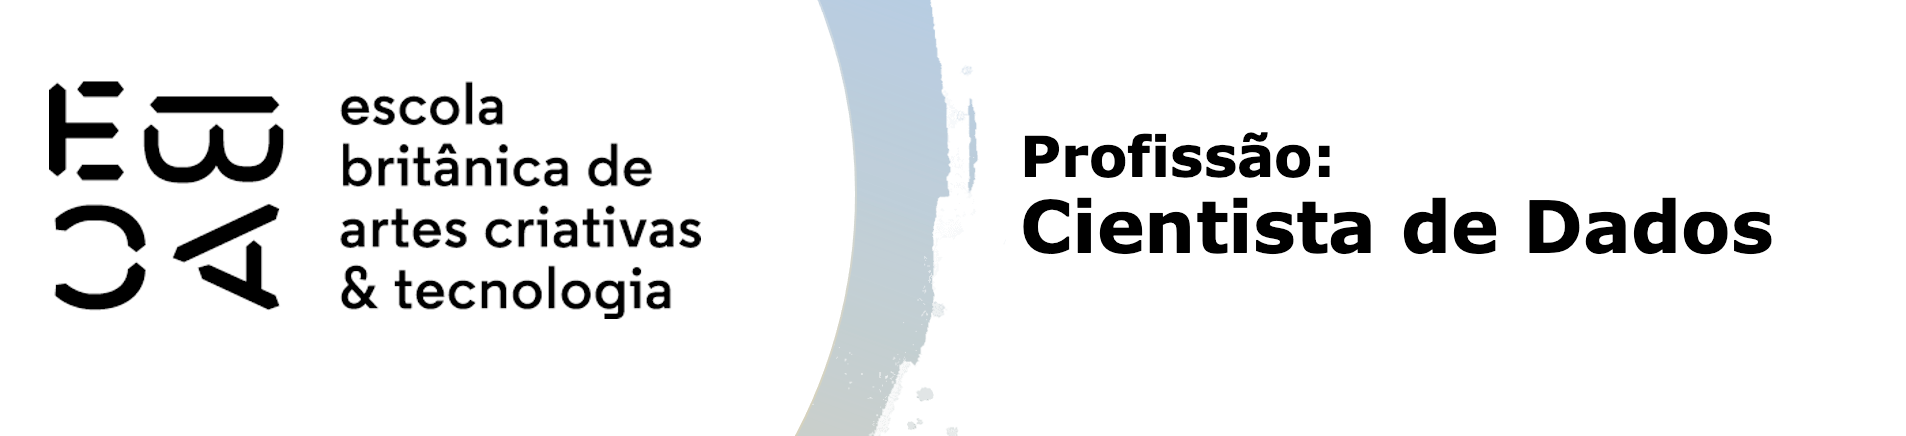

# Tarefa I

Neste projeto, estamos construindo um credit scoring para cartão de crédito, em um desenho amostral com 15 safras, e utilizando 12 meses de performance.

Carregue a base de dados ```credit_scoring.ftr```.

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

import statsmodels.formula.api as smf
import statsmodels.api as sm

from sklearn import metrics
from scipy.stats import ks_2samp
from scipy.stats import t

from statsmodels.stats.outliers_influence import variance_inflation_factor as vif

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.datasets import load_digits

In [2]:
df = pd.read_feather('credit_scoring.ftr')
df.head()

,data_ref,index,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,mau
0,2015-01-01,5733,F,N,N,0,Empresário,Médio,Solteiro,Casa,43,6.873973,1.0,2515.39,False
1,2015-01-01,727,F,S,S,0,Assalariado,Médio,Casado,Casa,35,4.526027,2.0,3180.19,False
2,2015-01-01,6374,F,N,N,2,Assalariado,Médio,Casado,Casa,31,0.243836,4.0,1582.29,False
3,2015-01-01,9566,F,N,N,0,Assalariado,Médio,Casado,Casa,54,12.772603,2.0,13721.17,False
4,2015-01-01,9502,F,S,N,0,Assalariado,Superior incompleto,Solteiro,Casa,31,8.432877,1.0,2891.08,False


In [3]:
df['tempo_emprego'].isna().sum()

125957

In [4]:
df['tempo_emprego'] = df['tempo_emprego'].fillna(df['tempo_emprego'].mean())
df['tempo_emprego'].isna().sum()

0

In [5]:
df['mau'] = df['mau'].astype('int64')
df.mau.dtype

dtype('int64')

## Amostragem

Separe os três últimos meses como safras de validação *out of time* (oot).

Variáveis:<br>
Considere que a variável ```data_ref``` não é uma variável explicativa, é somente uma variável indicadora da safra, e não deve ser utilizada na modelagem. A variávei ```index``` é um identificador do cliente, e também não deve ser utilizada como covariável (variável explicativa). As restantes podem ser utilizadas para prever a inadimplência, incluindo a renda.


In [6]:
"""out of time (oot)"""
ultimos_meses = df['data_ref'].sort_values().unique()[-3:]

df_oot = df[df['data_ref'].isin(ultimos_meses)]

df_treino = df[~df['data_ref'].isin(ultimos_meses)]

print("Base de treino:", df_treino.shape)
print("Base de validação:", df_oot.shape)

Base de treino: (600000, 15)
Base de validação: (150000, 15)


## Descritiva básica univariada

- Descreva a base quanto ao número de linhas, número de linhas para cada mês em ```data_ref```.
- Faça uma descritiva básica univariada de cada variável. Considere as naturezas diferentes: qualitativas e quantitativas.

In [7]:
print('numero de linhas: {0} \nnúmero de colunas: {1}'.format(df.shape[0], df.shape[1]))

df_mes = df.copy()
df_mes['ano_mes'] = df_mes['data_ref'].dt.to_period('M')
# df_mes.ano_mes.unique()

linhas_mes = df_mes.groupby('ano_mes').size()
print(f'Número de linha para cada mês:\n{linhas_mes}')

qualitativas = ['sexo', 'posse_de_veiculo', 'posse_de_imovel', 'tipo_renda', 
                'educacao', 'estado_civil', 'tipo_residencia']
quantitativas = ['qtd_filhos', 'idade', 'tempo_emprego', 'qt_pessoas_residencia', 'renda']

print('Contagem das Variáveis:\n')
for col in qualitativas:
    print(f"--- {col.upper()} ---")
    print(df[col].value_counts())
    print("\n")

print("--- DESCRITIVA QUANTITATIVA ---")
print(df[quantitativas].describe())



numero de linhas: 750000 
número de colunas: 15
Número de linha para cada mês:
ano_mes
2015-01    50000
2015-02    50000
2015-03    50000
2015-04    50000
2015-05    50000
2015-06    50000
2015-07    50000
2015-08    50000
2015-09    50000
2015-10    50000
2015-11    50000
2015-12    50000
2016-01    50000
2016-02    50000
2016-03    50000
Freq: M, dtype: int64
Contagem das Variáveis:

--- SEXO ---
sexo
F    504580
M    245420
Name: count, dtype: int64


--- POSSE_DE_VEICULO ---
posse_de_veiculo
N    457954
S    292046
Name: count, dtype: int64


--- POSSE_DE_IMOVEL ---
posse_de_imovel
S    503692
N    246308
Name: count, dtype: int64


--- TIPO_RENDA ---
tipo_renda
Assalariado         385740
Empresário          172712
Pensionista         126265
Servidor público     64922
Bolsista               361
Name: count, dtype: int64


--- EDUCACAO ---
educacao
Médio                  506836
Superior completo      204306
Superior incompleto     29471
Fundamental              8575
Pós graduação   

## Descritiva bivariada

Faça uma análise descritiva bivariada de cada variável

In [8]:
metadados = pd.DataFrame(df.dtypes, columns=['dtype'])
metadados['valores_unicos'] = df.nunique()


metadados = pd.DataFrame(df.dtypes, columns=['dtype'])
metadados['nmissing'] = df.isna().sum()
metadados['valores_unicos'] = df.nunique()
metadados['papel'] = 'covariavel'
metadados.loc['mau','papel'] = 'resposta'

In [9]:
def IV(variavel, resposta):
    tab = pd.crosstab(variavel, resposta, margins=True, margins_name='total')

    rótulo_evento = tab.columns[0]
    rótulo_nao_evento = tab.columns[1]

    tab['pct_evento'] = tab[rótulo_evento]/tab.loc['total',rótulo_evento]
    tab['ep'] = tab[rótulo_evento]/tab.loc['total',rótulo_evento]
    
    tab['pct_nao_evento'] = tab[rótulo_nao_evento]/tab.loc['total',rótulo_nao_evento]
    tab['woe'] = np.log(tab.pct_evento/tab.pct_nao_evento)
    tab['iv_parcial'] = (tab.pct_evento - tab.pct_nao_evento)*tab.woe
    return tab['iv_parcial'].sum()

for var in metadados[metadados.papel=='covariavel'].index:
    if  (metadados.loc[var, 'valores_unicos']>6):
        metadados.loc[var, 'IV'] = IV(pd.qcut(df[var],5,duplicates='drop'), df.mau)
    else: 
        metadados.loc[var, 'IV'] = IV(df[var], df.mau)

metadados

,dtype,nmissing,valores_unicos,papel,IV
data_ref,datetime64[ns],0,15,covariavel,0.345982
index,int64,0,16650,covariavel,0.002664
sexo,object,0,2,covariavel,0.002185
posse_de_veiculo,object,0,2,covariavel,0.000108
posse_de_imovel,object,0,2,covariavel,0.009693
qtd_filhos,int64,0,8,covariavel,0.000030
tipo_renda,object,0,5,covariavel,0.009360
educacao,object,0,5,covariavel,0.003547
estado_civil,object,0,5,covariavel,0.001126
tipo_residencia,object,0,6,covariavel,0.003045


,qt_mau,mau,posse_de_veiculo,cont,ep,mau_sup,mau_inf,logit,logit_sup,logit_inf,woe,woe_sup,woe_inf
posse_de_veiculo,,,,,,,,,,,,,
N,36082,0.078790,N,457954,0.000398,0.07957,0.078009,-2.458908,-2.448206,-2.469707,0.008280,0.018982,-0.002519
S,22561,0.077252,S,292046,0.000494,0.07822,0.076283,-2.480290,-2.466783,-2.493953,-0.013102,0.000405,-0.026765


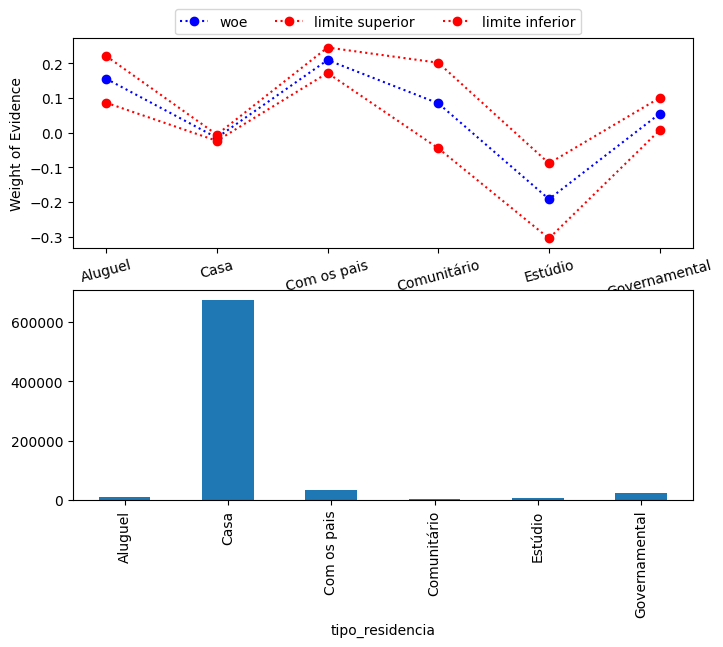

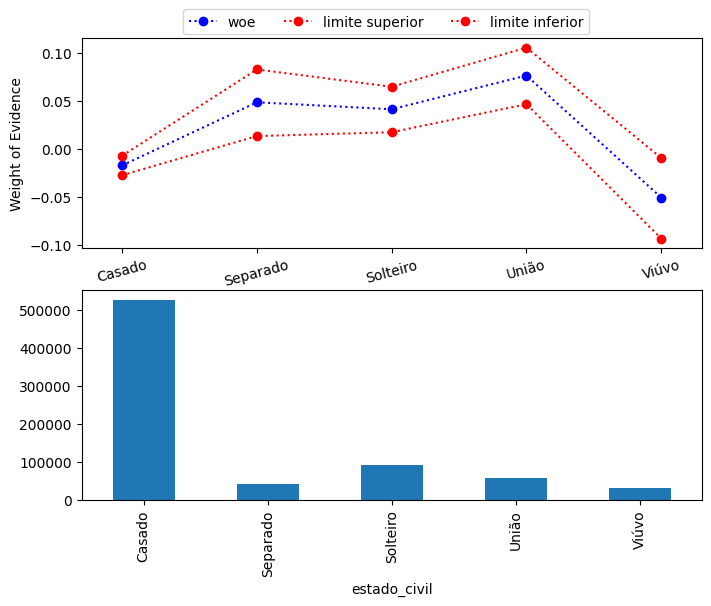

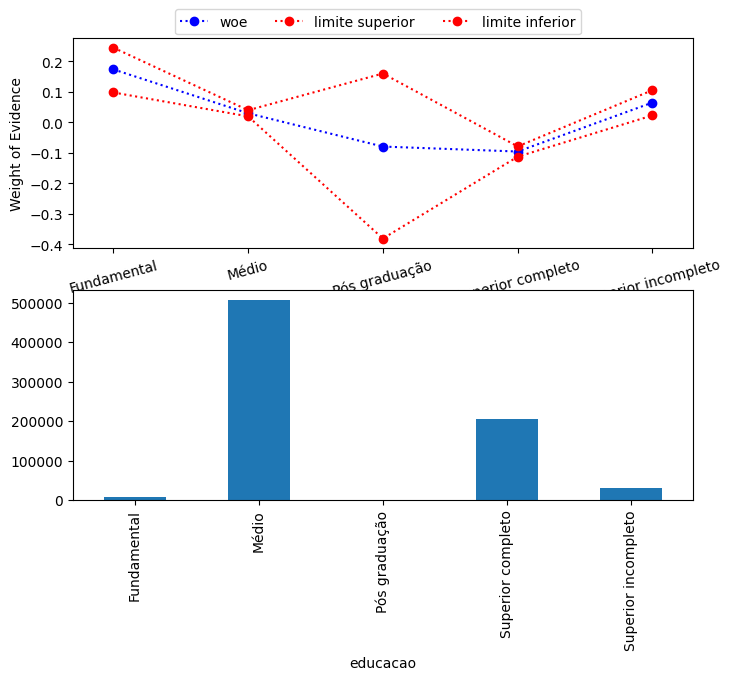

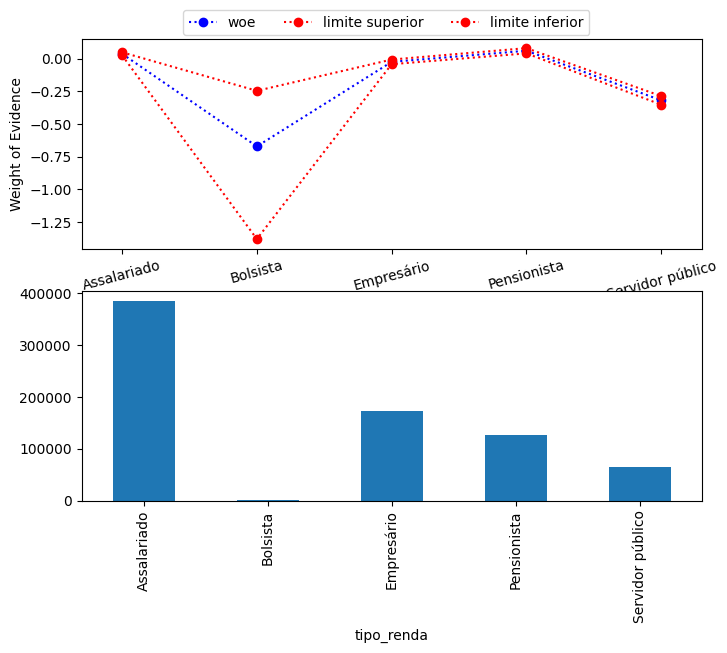

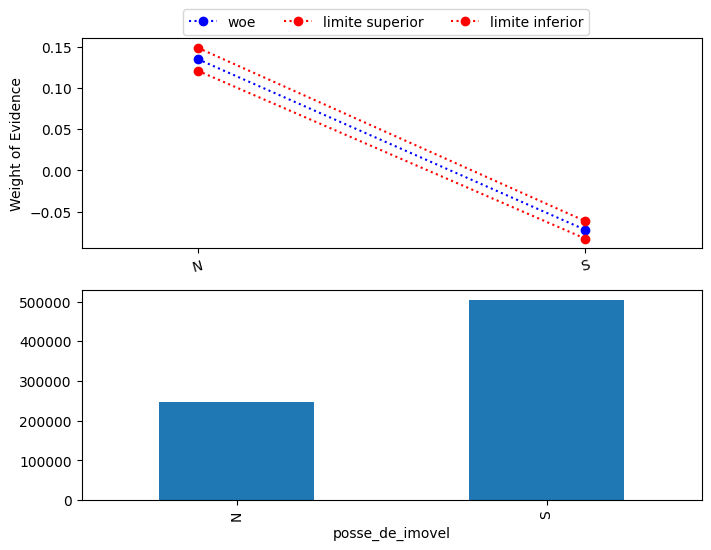

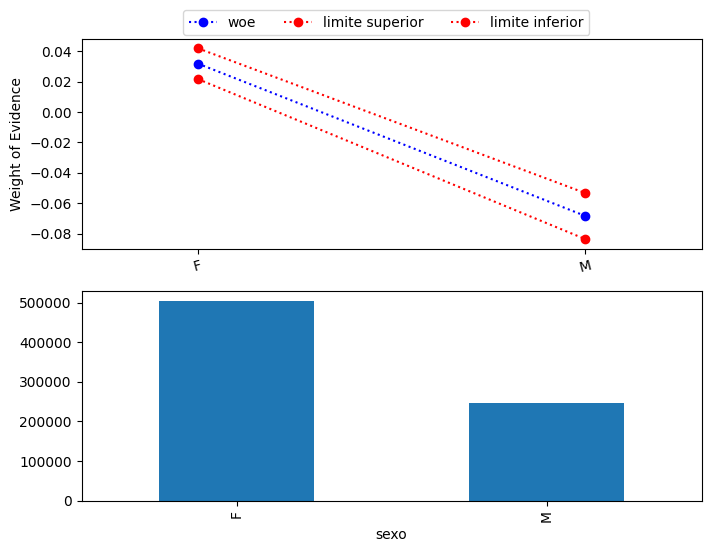

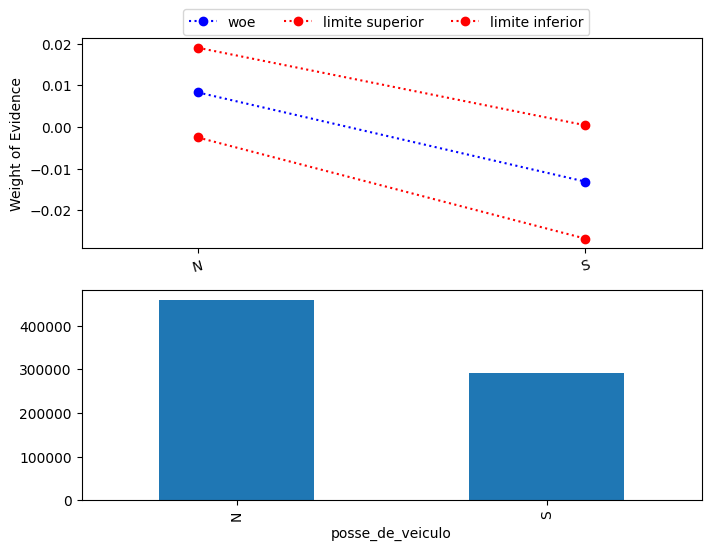

In [10]:
def biv_discreta(var, df):
    g = df.groupby(var)

    biv = pd.DataFrame({'qt_mau': g['mau'].sum(),
                        'mau':g['mau'].mean(), 
                        var: g['mau'].mean().index, 
                        'cont':g[var].count()})
    
    biv['ep'] = (biv.mau*(1-biv.mau)/biv.cont)**.5
    biv['mau_sup'] = biv.mau+t.ppf([0.975], biv.cont-1)*biv.ep
    biv['mau_inf'] = biv.mau+t.ppf([0.025], biv.cont-1)*biv.ep
    
    biv['logit'] = np.log(biv.mau/(1-biv.mau))
    biv['logit_sup'] = np.log(biv.mau_sup/(1-biv.mau_sup))
    biv['logit_inf'] = np.log(biv.mau_inf/(1-biv.mau_inf))

    tx_mau_geral = df.mau.mean()
    woe_geral = np.log(df.mau.mean() / (1 - df.mau.mean()))

    biv['woe'] = biv.logit - woe_geral
    biv['woe_sup'] = biv.logit_sup - woe_geral
    biv['woe_inf'] = biv.logit_inf - woe_geral

    fig, ax = plt.subplots(2,1, figsize=(8,6))
    ax[0].plot(biv[var], biv.woe, ':bo', label='woe')
    ax[0].plot(biv[var], biv.woe_sup, 'o:r', label='limite superior')
    ax[0].plot(biv[var], biv.woe_inf, 'o:r', label='limite inferior')
    
    num_cat = biv.shape[0]
    ax[0].set_xlim([-.3, num_cat-.7])

    ax[0].set_ylabel("Weight of Evidence")
    ax[0].legend(bbox_to_anchor=(.83, 1.17), ncol=3)
    
    ax[0].set_xticks(list(range(num_cat)))
    ax[0].set_xticklabels(biv[var], rotation=15)
    
    ax[1] = biv.cont.plot.bar()
    return biv

biv_discreta('tipo_residencia', df)

biv_discreta('estado_civil', df)

biv_discreta('educacao', df)

biv_discreta('tipo_renda', df)

biv_discreta('posse_de_imovel', df)

biv_discreta('sexo', df)

biv_discreta('posse_de_veiculo', df)

C:\Users\Adrielle\AppData\Local\Temp\ipykernel_14244\4219308114.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  g = df.groupby(cat_srs)
C:\Users\Adrielle\AppData\Local\Temp\ipykernel_14244\4219308114.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  g = df.groupby(cat_srs)
C:\Users\Adrielle\AppData\Local\Temp\ipykernel_14244\4219308114.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  g = df.groupby(cat_srs)
C:\U

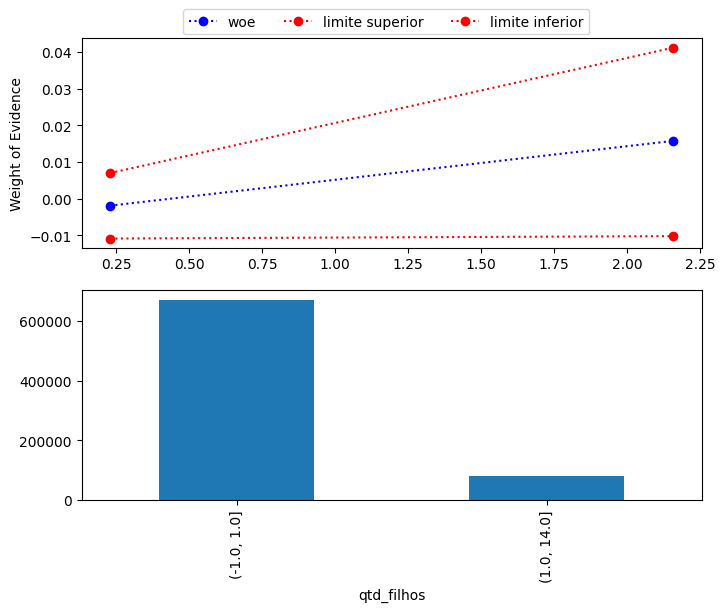

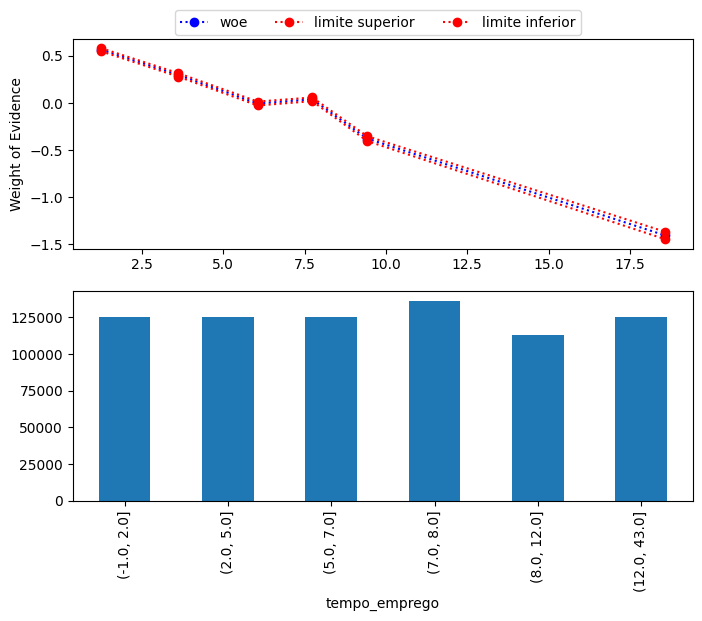

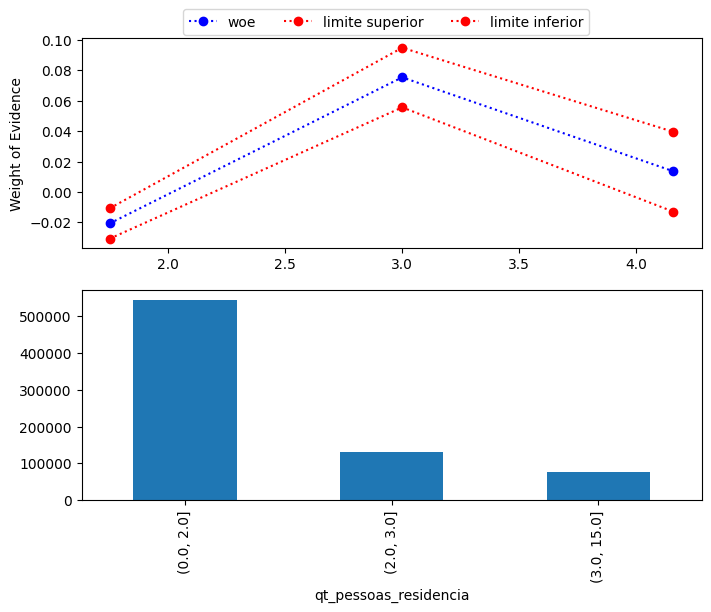

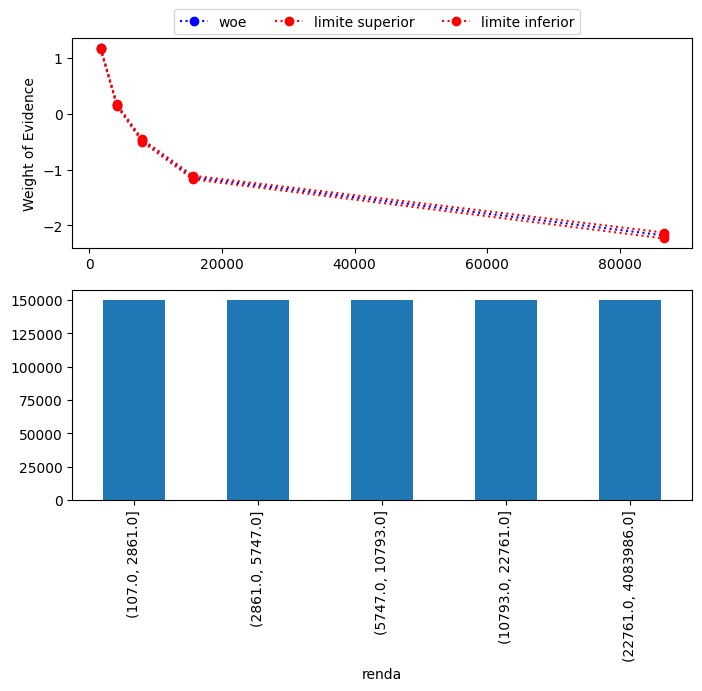

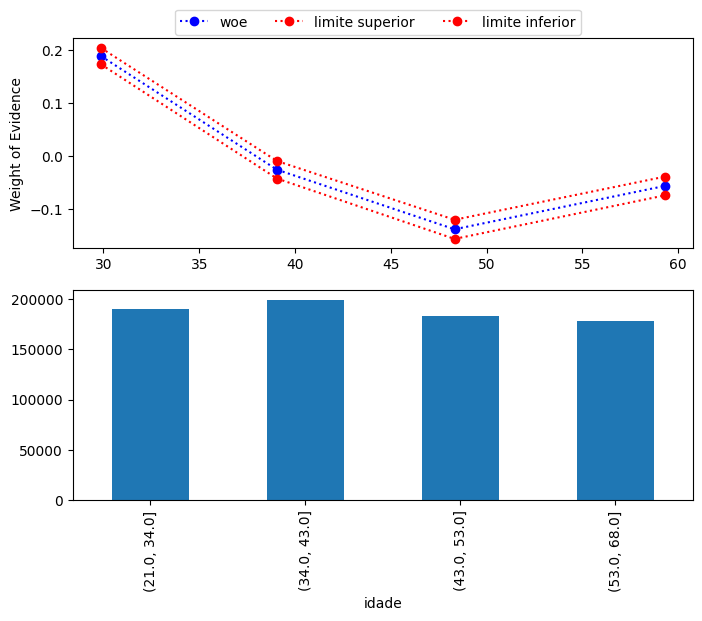

In [11]:
def biv_continua(var, ncat, df):
    cat_srs, bins = pd.qcut(df[var], ncat, retbins=True, precision=0, duplicates='drop')
    g = df.groupby(cat_srs)

    biv = pd.DataFrame({'qt_mau': g['mau'].sum(),
                        'mau':g['mau'].mean(), 
                        var: g[var].mean(), 
                        'cont':g[var].count()})
    
    biv['ep'] = (biv.mau*(1-biv.mau)/biv.cont)**.5
    biv['mau_sup'] = biv.mau+t.ppf([0.975], biv.cont-1)*biv.ep
    biv['mau_inf'] = biv.mau+t.ppf([0.025], biv.cont-1)*biv.ep
    
    biv['logit'] = np.log(biv.mau/(1-biv.mau))
    biv['logit_sup'] = np.log(biv.mau_sup/(1-biv.mau_sup))
    biv['logit_inf'] = np.log(biv.mau_inf/(1-biv.mau_inf))

    tx_mau_geral = df.mau.mean()
    woe_geral = np.log(df.mau.mean() / (1 - df.mau.mean()))

    biv['woe'] = biv.logit - woe_geral
    biv['woe_sup'] = biv.logit_sup - woe_geral
    biv['woe_inf'] = biv.logit_inf - woe_geral

    fig, ax = plt.subplots(2,1, figsize=(8,6))
    ax[0].plot(biv[var], biv.woe, ':bo', label='woe')
    ax[0].plot(biv[var], biv.woe_sup, 'o:r', label='limite superior')
    ax[0].plot(biv[var], biv.woe_inf, 'o:r', label='limite inferior')
    
    num_cat = biv.shape[0]

    ax[0].set_ylabel("Weight of Evidence")
    ax[0].legend(bbox_to_anchor=(.83, 1.17), ncol=3)
    
    ax[1] = biv.cont.plot.bar()
    return None

biv_continua('qtd_filhos', 5, df)

biv_continua('tempo_emprego', 6, df)

biv_continua('qt_pessoas_residencia', 4, df)

biv_continua('renda', 5, df)

biv_continua('idade', 4, df)

## Desenvolvimento do modelo

Desenvolva um modelo de *credit scoring* através de uma regressão logística.

- Trate valores missings e outliers
- Trate 'zeros estruturais'
- Faça agrupamentos de categorias conforme vimos em aula
- Proponha uma equação preditiva para 'mau'
- Caso hajam categorias não significantes, justifique

In [12]:
""" Testando o impacto da categorização em renda e tempo_emprego"""
def categorizar_variaveis(df, coluna, n_quantis):
    
    nome_categoria = coluna + '_categoria'
    df[nome_categoria] = pd.qcut(df[coluna], q=n_quantis, labels=False, duplicates='drop')
    return df

df_cat = df.copy()
# Categorizar a renda e o tempo de emprego
df_cat = categorizar_variaveis(df_cat, 'renda', 5)
df_cat = categorizar_variaveis(df_cat, 'tempo_emprego', 5)

renda_qcut = pd.qcut(df_cat['renda'], q=5).value_counts()
tempo_emprego_qcut = pd.qcut(df_cat['tempo_emprego'], q=5).value_counts()

print(f'Categorias:\n\n{renda_qcut}\n\n{tempo_emprego_qcut}')

Categorias:

renda
(107.669, 2860.64]         150003
(2860.64, 5746.59]         150000
(22761.344, 4083986.22]    150000
(10793.18, 22761.344]      149999
(5746.59, 10793.18]        149998
Name: count, dtype: int64

tempo_emprego
(5.759, 7.749]                  211812
(0.11699999999999999, 2.915]    150071
(2.915, 5.759]                  149999
(10.438, 42.907]                149928
(7.749, 10.438]                  88190
Name: count, dtype: int64


In [13]:
formula = 'mau ~ ' + ' + '.join([col for col in df.columns if col not in ['data_ref', 'index', 'mau']])
rl = smf.glm(formula, data=df_treino, family=sm.families.Binomial()).fit()

# rl.summary()

## Avaliação do modelo

Avalie o poder discriminante do modelo pelo menos avaliando acurácia, KS e Gini.

Avalie estas métricas nas bases de desenvolvimento e *out of time*.

In [14]:
df2 = df.copy()
df2['score'] = rl.predict(df)

# Acurácia
acc = metrics.accuracy_score(df2.mau, df2.score>.068)
#AUC
fpr, tpr, thresholds = metrics.roc_curve(df2.mau, df2.score)
auc = metrics.auc(fpr, tpr)
#Gini
gini = 2*auc -1
ks = ks_2samp(df2.loc[df2.mau == 1, 'score'], df2.loc[df2.mau != 1, 'score']).statistic

print('Acurácia: {0:.1%} \nAUC: {1:.1%} \nGINI: {2:.1%}\nKS: {3:.1%}'
      .format(acc, auc, gini, ks))

Acurácia: 54.1% 
AUC: 77.5% 
GINI: 55.0%
KS: 41.4%


In [15]:
""" oot """
rl_oot = smf.glm(formula, data=df_oot, family=sm.families.Binomial()).fit()

df4 = df.copy()
df4['score_oot'] = rl_oot.predict(df)

# Acurácia
acc = metrics.accuracy_score(df4.mau, df4.score_oot>.068)
#AUC
fpr, tpr, thresholds = metrics.roc_curve(df4.mau, df4.score_oot)
auc = metrics.auc(fpr, tpr)
#Gini
gini = 2*auc -1
ks = ks_2samp(df4.loc[df4.mau == 1, 'score_oot'], df4.loc[df4.mau != 1, 'score_oot']).statistic

print('Acurácia: {0:.1%} \nAUC: {1:.1%} \nGINI: {2:.1%}\nKS: {3:.1%}'
      .format(acc, auc, gini, ks))

C:\Users\Adrielle\anaconda3\envs\pycaret-streamlit-11\Lib\site-packages\statsmodels\genmod\families\links.py:198: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)


Acurácia: 59.5% 
AUC: 78.0% 
GINI: 55.9%
KS: 41.8%


---

# a - Criar um pipeline utilizando o sklearn pipeline para o preprocessamento 

## Pré processamento

### Substituição de nulos (nans)

Existe nulos na base? é dado numérico ou categórico? qual o valor de substituição? média? valor mais frequente? etc

### Remoção de outliers

Como identificar outlier? Substituir o outlier por algum valor? Remover a linha?

### Seleção de variáveis

Qual tipo de técnica? Boruta? Feature importance? 

### Redução de dimensionalidade (PCA)

Aplicar PCA para reduzir a dimensionalidade para 5

### Criação de dummies

Aplicar o get_dummies() ou onehotencoder() para transformar colunas catégoricas do dataframe em colunas de 0 e 1. 
- sexo
- posse_de_veiculo
- posse_de_imovel
- tipo_renda
- educacao
- estado_civil
- tipo_residencia

### Pipeline 

Crie um pipeline contendo essas funções.

preprocessamento()
- substituicao de nulos
- remoção outliers
- PCA
- Criação de dummy de pelo menos 1 variável (posse_de_veiculo)

In [16]:
df.head()

,data_ref,index,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,mau
0,2015-01-01,5733,F,N,N,0,Empresário,Médio,Solteiro,Casa,43,6.873973,1.0,2515.39,0
1,2015-01-01,727,F,S,S,0,Assalariado,Médio,Casado,Casa,35,4.526027,2.0,3180.19,0
2,2015-01-01,6374,F,N,N,2,Assalariado,Médio,Casado,Casa,31,0.243836,4.0,1582.29,0
3,2015-01-01,9566,F,N,N,0,Assalariado,Médio,Casado,Casa,54,12.772603,2.0,13721.17,0
4,2015-01-01,9502,F,S,N,0,Assalariado,Superior incompleto,Solteiro,Casa,31,8.432877,1.0,2891.08,0


In [17]:
df.isna().sum().sum()

0

In [18]:
df.head()

,data_ref,index,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,mau
0,2015-01-01,5733,F,N,N,0,Empresário,Médio,Solteiro,Casa,43,6.873973,1.0,2515.39,0
1,2015-01-01,727,F,S,S,0,Assalariado,Médio,Casado,Casa,35,4.526027,2.0,3180.19,0
2,2015-01-01,6374,F,N,N,2,Assalariado,Médio,Casado,Casa,31,0.243836,4.0,1582.29,0
3,2015-01-01,9566,F,N,N,0,Assalariado,Médio,Casado,Casa,54,12.772603,2.0,13721.17,0
4,2015-01-01,9502,F,S,N,0,Assalariado,Superior incompleto,Solteiro,Casa,31,8.432877,1.0,2891.08,0


In [19]:
dataset = df.sample(5000)

dataset.drop(['data_ref','index'], axis=1, inplace=True)
categorical_columns = dataset.select_dtypes(include=['object']).columns
dataset = pd.get_dummies(dataset, columns=categorical_columns, drop_first=True)
dataset.qtd_filhos = dataset.qtd_filhos.astype(float)

X = dataset.drop(columns=['mau'])
y = dataset['mau']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=10)

In [20]:
dataset.head()

,qtd_filhos,idade,tempo_emprego,qt_pessoas_residencia,renda,mau,sexo_M,posse_de_veiculo_S,posse_de_imovel_S,tipo_renda_Bolsista,...,educacao_Superior incompleto,estado_civil_Separado,estado_civil_Solteiro,estado_civil_União,estado_civil_Viúvo,tipo_residencia_Casa,tipo_residencia_Com os pais,tipo_residencia_Comunitário,tipo_residencia_Estúdio,tipo_residencia_Governamental
525489,0.0,51,6.638356,2.0,18463.13,1,False,True,True,False,...,False,False,False,False,False,True,False,False,False,False
440979,0.0,52,7.032877,2.0,14780.88,0,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
363817,0.0,46,6.238356,2.0,24290.93,0,False,True,True,False,...,False,False,False,False,False,False,False,False,True,False
309647,2.0,37,1.260274,4.0,7427.77,0,True,False,True,False,...,False,False,False,False,False,True,False,False,False,False
36358,1.0,41,4.131507,3.0,1689.31,1,True,False,True,False,...,False,False,False,False,False,True,False,False,False,False


In [21]:
# Define a PCA to Linear dimensionality reduction
pca_pipe = PCA(n_components=15)

# Define a Standard Scaler to normalize inputs
scaler_pipe = StandardScaler()

# set the tolerance to a large value to make the example faster
logistic_pipe = LogisticRegression(max_iter=200)

In [22]:
pipe = Pipeline(steps=[("scaler", scaler_pipe), 
                       ("pca", pca_pipe), 
                       ("logistic", logistic_pipe)])

In [23]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()), ('pca', PCA(n_components=15)),
                ('logistic', LogisticRegression(max_iter=200))])

In [24]:
pipe[1].transform(X_train)

C:\Users\Adrielle\anaconda3\envs\pycaret-streamlit-11\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(


array([[-2.72032124e+03, -6.31940824e+03, -4.47021796e+03, ...,
        -7.23062403e+01, -2.09067348e+03,  4.12781682e+03],
       [-3.73301085e+02, -8.44658780e+02, -5.99968943e+02, ...,
        -9.80735414e+00, -2.80730629e+02,  5.56215960e+02],
       [-1.94844578e+02, -3.85379131e+02, -2.75529353e+02, ...,
        -4.76542415e+00, -1.30409364e+02,  2.61278253e+02],
       ...,
       [-1.31847396e+04, -3.08340863e+04, -2.17997698e+04, ...,
        -3.52738773e+02, -1.01915758e+04,  2.01064595e+04],
       [-9.65877191e+02, -2.23215542e+03, -1.58023670e+03, ...,
        -2.56982737e+01, -7.39405933e+02,  1.46069211e+03],
       [-7.94716903e+02, -1.83641309e+03, -1.30136578e+03, ...,
        -2.12349231e+01, -6.08837893e+02,  1.20269992e+03]])

In [25]:
pca_pipe.transform(X_train)

C:\Users\Adrielle\anaconda3\envs\pycaret-streamlit-11\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(


array([[-2.72032124e+03, -6.31940824e+03, -4.47021796e+03, ...,
        -7.23062403e+01, -2.09067348e+03,  4.12781682e+03],
       [-3.73301085e+02, -8.44658780e+02, -5.99968943e+02, ...,
        -9.80735414e+00, -2.80730629e+02,  5.56215960e+02],
       [-1.94844578e+02, -3.85379131e+02, -2.75529353e+02, ...,
        -4.76542415e+00, -1.30409364e+02,  2.61278253e+02],
       ...,
       [-1.31847396e+04, -3.08340863e+04, -2.17997698e+04, ...,
        -3.52738773e+02, -1.01915758e+04,  2.01064595e+04],
       [-9.65877191e+02, -2.23215542e+03, -1.58023670e+03, ...,
        -2.56982737e+01, -7.39405933e+02,  1.46069211e+03],
       [-7.94716903e+02, -1.83641309e+03, -1.30136578e+03, ...,
        -2.12349231e+01, -6.08837893e+02,  1.20269992e+03]])

---

# Tarefa II

## Treinar um modelo de regressão logistica

In [26]:
df= df.sample(50000)
df.drop(['data_ref','index'], axis=1, inplace=True)

In [27]:
from pycaret.classification import *

exp_clf101 = setup(data = df, target = 'mau', session_id=123) 

,Description,Value
0,Session id,123
1,Target,mau
2,Target type,Binary
3,Original data shape,"(50000, 13)"
4,Transformed data shape,"(50000, 30)"
5,Transformed train set shape,"(35000, 30)"
6,Transformed test set shape,"(15000, 30)"
7,Numeric features,5
8,Categorical features,7
9,Preprocess,True


In [28]:
#ordenando a tabela por AUC
best_model = compare_models(fold=10, sort='AUC')

print(best_model)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
svm,SVM - Linear Kernel,0.8943,0.7824,0.2328,0.2498,0.2134,0.1692,0.1739,0.3280
gbc,Gradient Boosting Classifier,0.9216,0.7815,0.0230,0.4812,0.0438,0.0368,0.0911,2.6550
ada,Ada Boost Classifier,0.9215,0.7799,0.0274,0.4427,0.0513,0.0432,0.0939,1.1180
lr,Logistic Regression,0.9218,0.7761,0.0000,0.0000,0.0000,0.0000,0.0000,4.1440
lightgbm,Light Gradient Boosting Machine,0.9214,0.7741,0.0270,0.4649,0.0509,0.0426,0.0963,0.6400
rf,Random Forest Classifier,0.9004,0.7066,0.0902,0.1994,0.1241,0.0792,0.0863,2.4340
nb,Naive Bayes,0.6407,0.6849,0.6118,0.1271,0.2102,0.0929,0.1417,0.2960
qda,Quadratic Discriminant Analysis,0.1923,0.6602,0.9839,0.0872,0.1602,0.0192,0.0908,0.5030
knn,K Neighbors Classifier,0.9149,0.6422,0.0840,0.3282,0.1334,0.1050,0.1328,0.9970
ridge,Ridge Classifier,0.9218,0.6412,0.0000,0.0000,0.0000,0.0000,0.0000,0.2450


SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.001, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=-1, penalty='l2',
              power_t=0.5, random_state=123, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)


In [29]:
models()

,Name,Reference,Turbo
ID,,,
lr,Logistic Regression,sklearn.linear_model._logistic.LogisticRegression,True
knn,K Neighbors Classifier,sklearn.neighbors._classification.KNeighborsCl...,True
nb,Naive Bayes,sklearn.naive_bayes.GaussianNB,True
dt,Decision Tree Classifier,sklearn.tree._classes.DecisionTreeClassifier,True
svm,SVM - Linear Kernel,sklearn.linear_model._stochastic_gradient.SGDC...,True
rbfsvm,SVM - Radial Kernel,sklearn.svm._classes.SVC,False
gpc,Gaussian Process Classifier,sklearn.gaussian_process._gpc.GaussianProcessC...,False
mlp,MLP Classifier,sklearn.neural_network._multilayer_perceptron....,False
ridge,Ridge Classifier,sklearn.linear_model._ridge.RidgeClassifier,True


In [30]:
lr = create_model('lr')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9220,0.7619,0.0000,0.0000,0.0000,0.0000,0.0000
1,0.9220,0.7831,0.0000,0.0000,0.0000,0.0000,0.0000
2,0.9217,0.7855,0.0000,0.0000,0.0000,0.0000,0.0000
3,0.9217,0.7716,0.0000,0.0000,0.0000,0.0000,0.0000
4,0.9217,0.7806,0.0000,0.0000,0.0000,0.0000,0.0000
5,0.9217,0.7622,0.0000,0.0000,0.0000,0.0000,0.0000
6,0.9217,0.7755,0.0000,0.0000,0.0000,0.0000,0.0000
7,0.9217,0.7907,0.0000,0.0000,0.0000,0.0000,0.0000
8,0.9217,0.7821,0.0000,0.0000,0.0000,0.0000,0.0000


In [ ]:
"""Original model was better than the tuned model, hence it will be returned."""

In [32]:
predict_model(lr)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Logistic Regression,0.9217,0.7718,0.0000,0.0000,0.0000,0.0000,0.0000


,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,mau,prediction_label,prediction_score
677384,F,S,N,0,Empresário,Médio,Separado,Casa,42,18.602739,1.0,39625.730469,0,0,0.9988
109379,M,N,S,0,Empresário,Superior completo,União,Casa,48,2.975343,2.0,2898.610107,0,0,0.8640
89837,F,N,N,0,Empresário,Médio,Casado,Casa,39,3.175343,2.0,2768.570068,0,0,0.8573
309652,M,S,S,0,Assalariado,Superior incompleto,Casado,Casa,43,4.131507,2.0,11571.269531,0,0,0.9480
10923,F,N,N,0,Assalariado,Médio,Solteiro,Com os pais,27,8.361644,1.0,2388.729980,0,0,0.8285
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
568711,M,S,S,0,Servidor público,Superior completo,Solteiro,Casa,27,2.263014,1.0,3634.199951,0,0,0.8852
112211,F,N,S,1,Servidor público,Médio,Solteiro,Casa,34,3.698630,2.0,2957.510010,0,0,0.8692
163092,F,N,S,0,Pensionista,Médio,Viúvo,Casa,66,7.748574,1.0,34212.531250,0,0,0.9966
213694,F,S,N,0,Assalariado,Médio,Casado,Casa,49,1.800000,2.0,4008.070068,0,0,0.8633


In [33]:
final_lr = finalize_model(lr)

## Salvar o pickle file do modelo treinado

In [34]:
import pickle

arquivo = 'Final lr Model 02Fev2024.pkl'
pickle.dump(final_lr, open(arquivo, 'wb'))

---

# Pycaret na base de dados 

Utilize o pycaret para pre processar os dados e rodar o modelo **lightgbm**. Faça todos os passos a passos da aula e gere os gráficos finais. E o pipeline de toda a transformação.



In [43]:
lightgbm = create_model('lightgbm')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9209,0.7595,0.0147,0.3333,0.0281,0.0216,0.0558
1,0.9229,0.7784,0.0256,0.6364,0.0493,0.0435,0.1169
2,0.9203,0.7867,0.0182,0.3333,0.0346,0.0267,0.0623
3,0.9206,0.7665,0.0292,0.4000,0.0544,0.0442,0.0908
4,0.9234,0.7816,0.0401,0.6875,0.0759,0.0678,0.1537
5,0.9197,0.7541,0.0255,0.3333,0.0475,0.0367,0.0738
6,0.9211,0.7683,0.0401,0.4583,0.0738,0.0620,0.1176
7,0.9203,0.7944,0.0182,0.3333,0.0346,0.0267,0.0623
8,0.9226,0.7882,0.0365,0.5882,0.0687,0.0601,0.1326


In [44]:
tuned_lightgbm = tune_model(lightgbm, optimize='F1')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9151,0.7257,0.0696,0.3065,0.1134,0.0871,0.1144
1,0.9126,0.7389,0.0549,0.2381,0.0893,0.0618,0.0808
2,0.9103,0.7439,0.0766,0.2561,0.1180,0.0850,0.1025
3,0.9111,0.7224,0.1022,0.3011,0.1526,0.1176,0.1370
4,0.9120,0.7317,0.0876,0.2927,0.1348,0.1025,0.1236
5,0.9074,0.7154,0.0803,0.2340,0.1196,0.0829,0.0963
6,0.9051,0.7385,0.0620,0.1848,0.0929,0.0557,0.0651
7,0.9114,0.7574,0.0839,0.2805,0.1292,0.0966,0.1166
8,0.9057,0.7598,0.0730,0.2083,0.1081,0.0703,0.0813


Fitting 10 folds for each of 10 candidates, totalling 100 fits


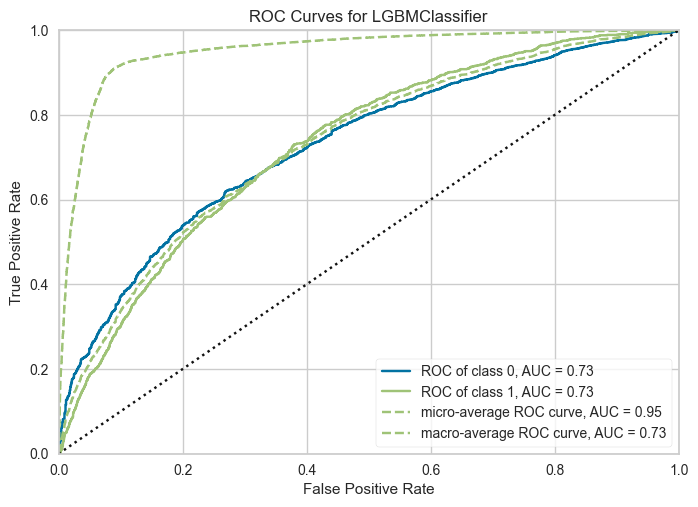

In [45]:
plot_model(tuned_lightgbm, plot = 'auc')

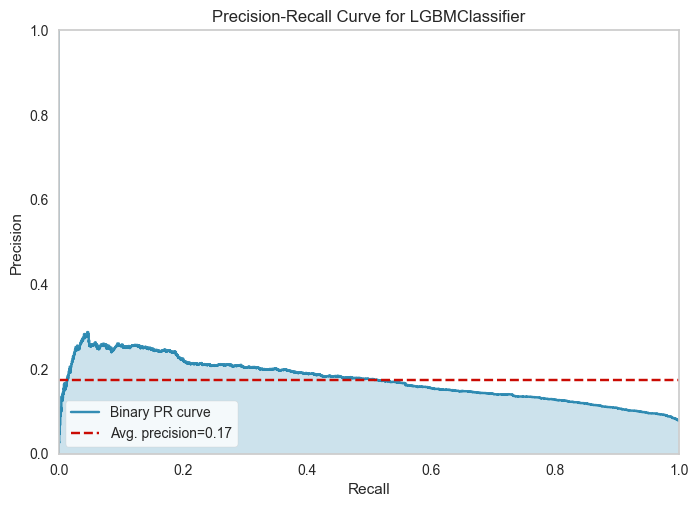

In [46]:
plot_model(tuned_lightgbm, plot = 'pr')

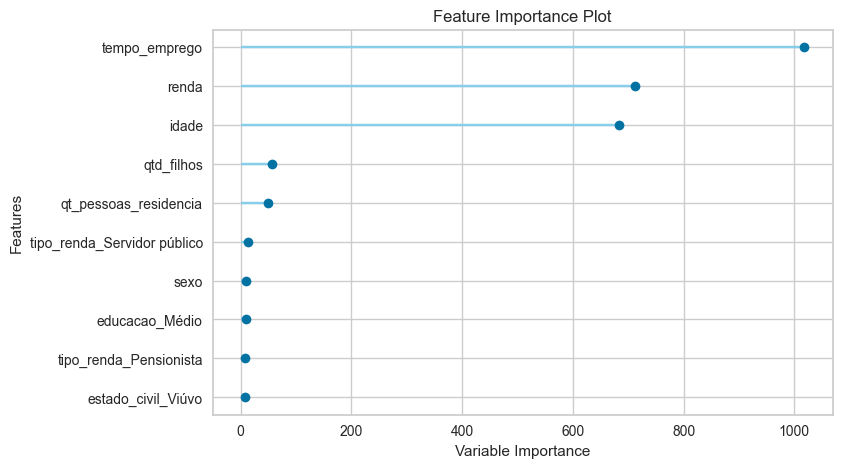

In [47]:
plot_model(tuned_lightgbm, plot='feature')

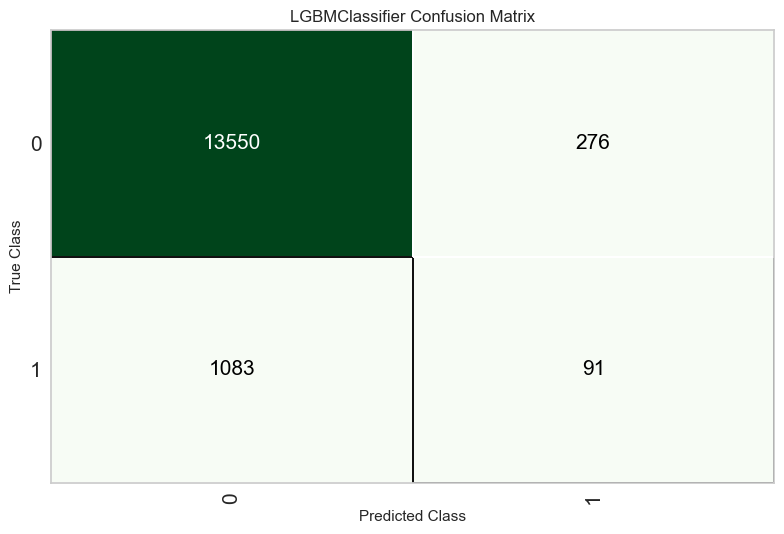

In [48]:
plot_model(tuned_lightgbm, plot='confusion_matrix')

In [49]:
predict_model(tuned_lightgbm)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Light Gradient Boosting Machine,0.9094,0.7308,0.0775,0.2480,0.1181,0.0840,0.1001


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,mau,prediction_label,prediction_score
677384,F,S,N,0,Empresário,Médio,Separado,Casa,42,18.602739,1.0,39625.730469,0,0,0.9996
109379,M,N,S,0,Empresário,Superior completo,União,Casa,48,2.975343,2.0,2898.610107,0,0,0.9571
89837,F,N,N,0,Empresário,Médio,Casado,Casa,39,3.175343,2.0,2768.570068,0,0,0.9246
309652,M,S,S,0,Assalariado,Superior incompleto,Casado,Casa,43,4.131507,2.0,11571.269531,0,0,0.9955
10923,F,N,N,0,Assalariado,Médio,Solteiro,Com os pais,27,8.361644,1.0,2388.729980,0,0,0.8361
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
568711,M,S,S,0,Servidor público,Superior completo,Solteiro,Casa,27,2.263014,1.0,3634.199951,0,0,0.8729
112211,F,N,S,1,Servidor público,Médio,Solteiro,Casa,34,3.698630,2.0,2957.510010,0,0,0.7943
163092,F,N,S,0,Pensionista,Médio,Viúvo,Casa,66,7.748574,1.0,34212.531250,0,0,0.9985
213694,F,S,N,0,Assalariado,Médio,Casado,Casa,49,1.800000,2.0,4008.070068,0,0,0.9301


In [50]:
final_lightgbm = finalize_model(tuned_lightgbm)

### Salvar o arquivo do modelo treinado

In [53]:
save_model(final_lightgbm,'Final lightgbm Model 02Fev2024')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=Memory(location=None),
          steps=[('numerical_imputer',
                  TransformerWrapper(exclude=None,
                                     include=['qtd_filhos', 'idade',
                                              'tempo_emprego',
                                              'qt_pessoas_residencia', 'renda'],
                                     transformer=SimpleImputer(add_indicator=False,
                                                               copy=True,
                                                               fill_value=None,
                                                               keep_empty_features=False,
                                                               missing_values=nan,
                                                               strategy='mean'))),
                 ('categorical_imputer',
                  TransformerWra...
                                 boosting_type='gbdt', class_weight=None,
            

---